---
---

<h1 style="color:#1E90FF;">License Plate Recognition (LPR) Project</h1>

<h2 style="color:#2E8B57;">Objective</h2>

Recognize and extract text from vehicle license plates using Optical Character Recognition (OCR) techniques.

<h2 style="color:#2E8B57;">Overview</h2>

- Dataset download and loading of vehicle images with XML annotations.  
- Visualization of license plate bounding boxes on images.  
- Image preprocessing and cropping of license plate regions.  
- Text extraction from cropped plates using Tesseract OCR.  
- Post-processing and cleaning of extracted text.  
- Conversion of annotations into YOLO format for object detection.  
- Preparation for training a CRNN-based OCR model.

<h2 style="color:#2E8B57;">Project Structure</h2>

- <code>dataset/</code> - Raw images and annotation files  
- <code>cropped_plates/</code> - Cropped and preprocessed license plate images  
- <code>annotations_yolo/</code> - YOLO formatted annotation files  
- <code>ocr_results/</code> - Extracted text results from license plates

<h2 style="color:#2E8B57;">Technologies Used</h2>

- Python 3.x  
- OpenCV  
- Tesseract OCR  
- XML Parsing (ElementTree)  
- PyTorch (for CRNN model)

<h2 style="color:#2E8B57;">Results and Next Steps</h2>

- Successfully extracted license plate text with good accuracy  
- Verified bounding boxes visually for correctness  
- Preparing dataset and training deep learning OCR models for improved accuracy

<h2 style="color:#2E8B57;">References</h2>

- <a href="https://github.com/tesseract-ocr/tesseract" style="color:#FF4500; text-decoration: underline;">Tesseract OCR official documentation</a>  
- <a href="https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects" style="color:#FF4500; text-decoration: underline;">YOLO annotation format guidelines</a>  
- <a href="https://arxiv.org/abs/1507.05717" style="color:#FF4500; text-decoration: underline;">CRNN research paper</a>

<h2 style="color:#2E8B57;">Acknowledgments</h2>

Thanks to all open-source projects and contributors whose tools and datasets made this work possible.

For any questions or feedback, please feel free to reach out.

---
---

----
----

In [84]:
# **Install Required Libraries**

In [85]:
!pip install kagglehub pytesseract opencv-python torch torchvision matplotlib pandas scikit-learn

In [86]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.


In [87]:
# **Imports & Initial Setup**

In [88]:
import os

In [89]:
import kagglehub

In [90]:
import xml.etree.ElementTree as ET

In [91]:
import pandas as pd

In [92]:
import cv2

In [93]:
import pytesseract

In [94]:
import matplotlib.pyplot as plt

In [95]:
import matplotlib.patches as patches

In [96]:
import random

In [97]:
import shutil

In [98]:
import re

In [99]:
import numpy as np

In [100]:
from PIL import Image

In [101]:
from sklearn.model_selection import train_test_split

In [102]:
from torchvision import transforms

In [103]:
import torch

In [104]:
import torch.nn as nn

In [105]:
from torch.utils.data import Dataset, DataLoader

In [106]:
import torch.optim as optim

In [107]:
# Ensure outputs are visible

In [108]:
from IPython.display import display, HTML

In [109]:
display(HTML("<style>.output { max-height: 10000px; }</style>"))

---
---

---
---

In [110]:
# **Download & Load Dataset**

In [111]:
dataset_path = kagglehub.dataset_download("andrewmvd/car-plate-detection")

In [112]:
print(f"Dataset downloaded to: {dataset_path}")

Dataset downloaded to: /kaggle/input/car-plate-detection


In [113]:
# Define paths

In [114]:
ann_path = os.path.join(dataset_path, "annotations")

In [115]:
img_path = os.path.join(dataset_path, "images")

In [116]:
# Verify files

In [117]:
print("\n Dataset Structure:")
print(f"Annotations: {len(os.listdir(ann_path))} XML files")
print(f"Images: {len(os.listdir(img_path))} PNG files")
print("\nSample files:")
print("Annotations:", os.listdir(ann_path)[:3])
print("Images:", os.listdir(img_path)[:3])


 Dataset Structure:
Annotations: 433 XML files
Images: 433 PNG files

Sample files:
Annotations: ['Cars339.xml', 'Cars13.xml', 'Cars74.xml']
Images: ['Cars393.png', 'Cars376.png', 'Cars87.png']


---
---

---
---

In [118]:
# **Step 3: Parse Annotations & Create DataFrame**

In [119]:
records = []
for ann_file in os.listdir(ann_path):
    tree = ET.parse(os.path.join(ann_path, ann_file))
    root = tree.getroot()

    filename = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        records.append({
            'filename': filename,
            'width': width,
            'height': height,
            'label': label,
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        })

In [120]:
df = pd.DataFrame(records)

In [121]:
print(f"\n Parsed {len(df)} license plate annotations.")


 Parsed 471 license plate annotations.


In [122]:
print("\n DataFrame Sample:")
display(df.head())


 DataFrame Sample:


filename  width  height    label  xmin  ymin  xmax  ymax
0  Cars339.png    500     300  licence   209   135   283   169
1   Cars13.png    400     268  licence   191   147   242   169
2   Cars74.png    400     267  licence   115   115   277   153
3   Cars16.png    400     221  licence    36   175    62   186
4  Cars291.png    517     303  licence    71   205   215   246

---
---

---
---

In [123]:
# **Visualize Bounding Boxes (Sample)**

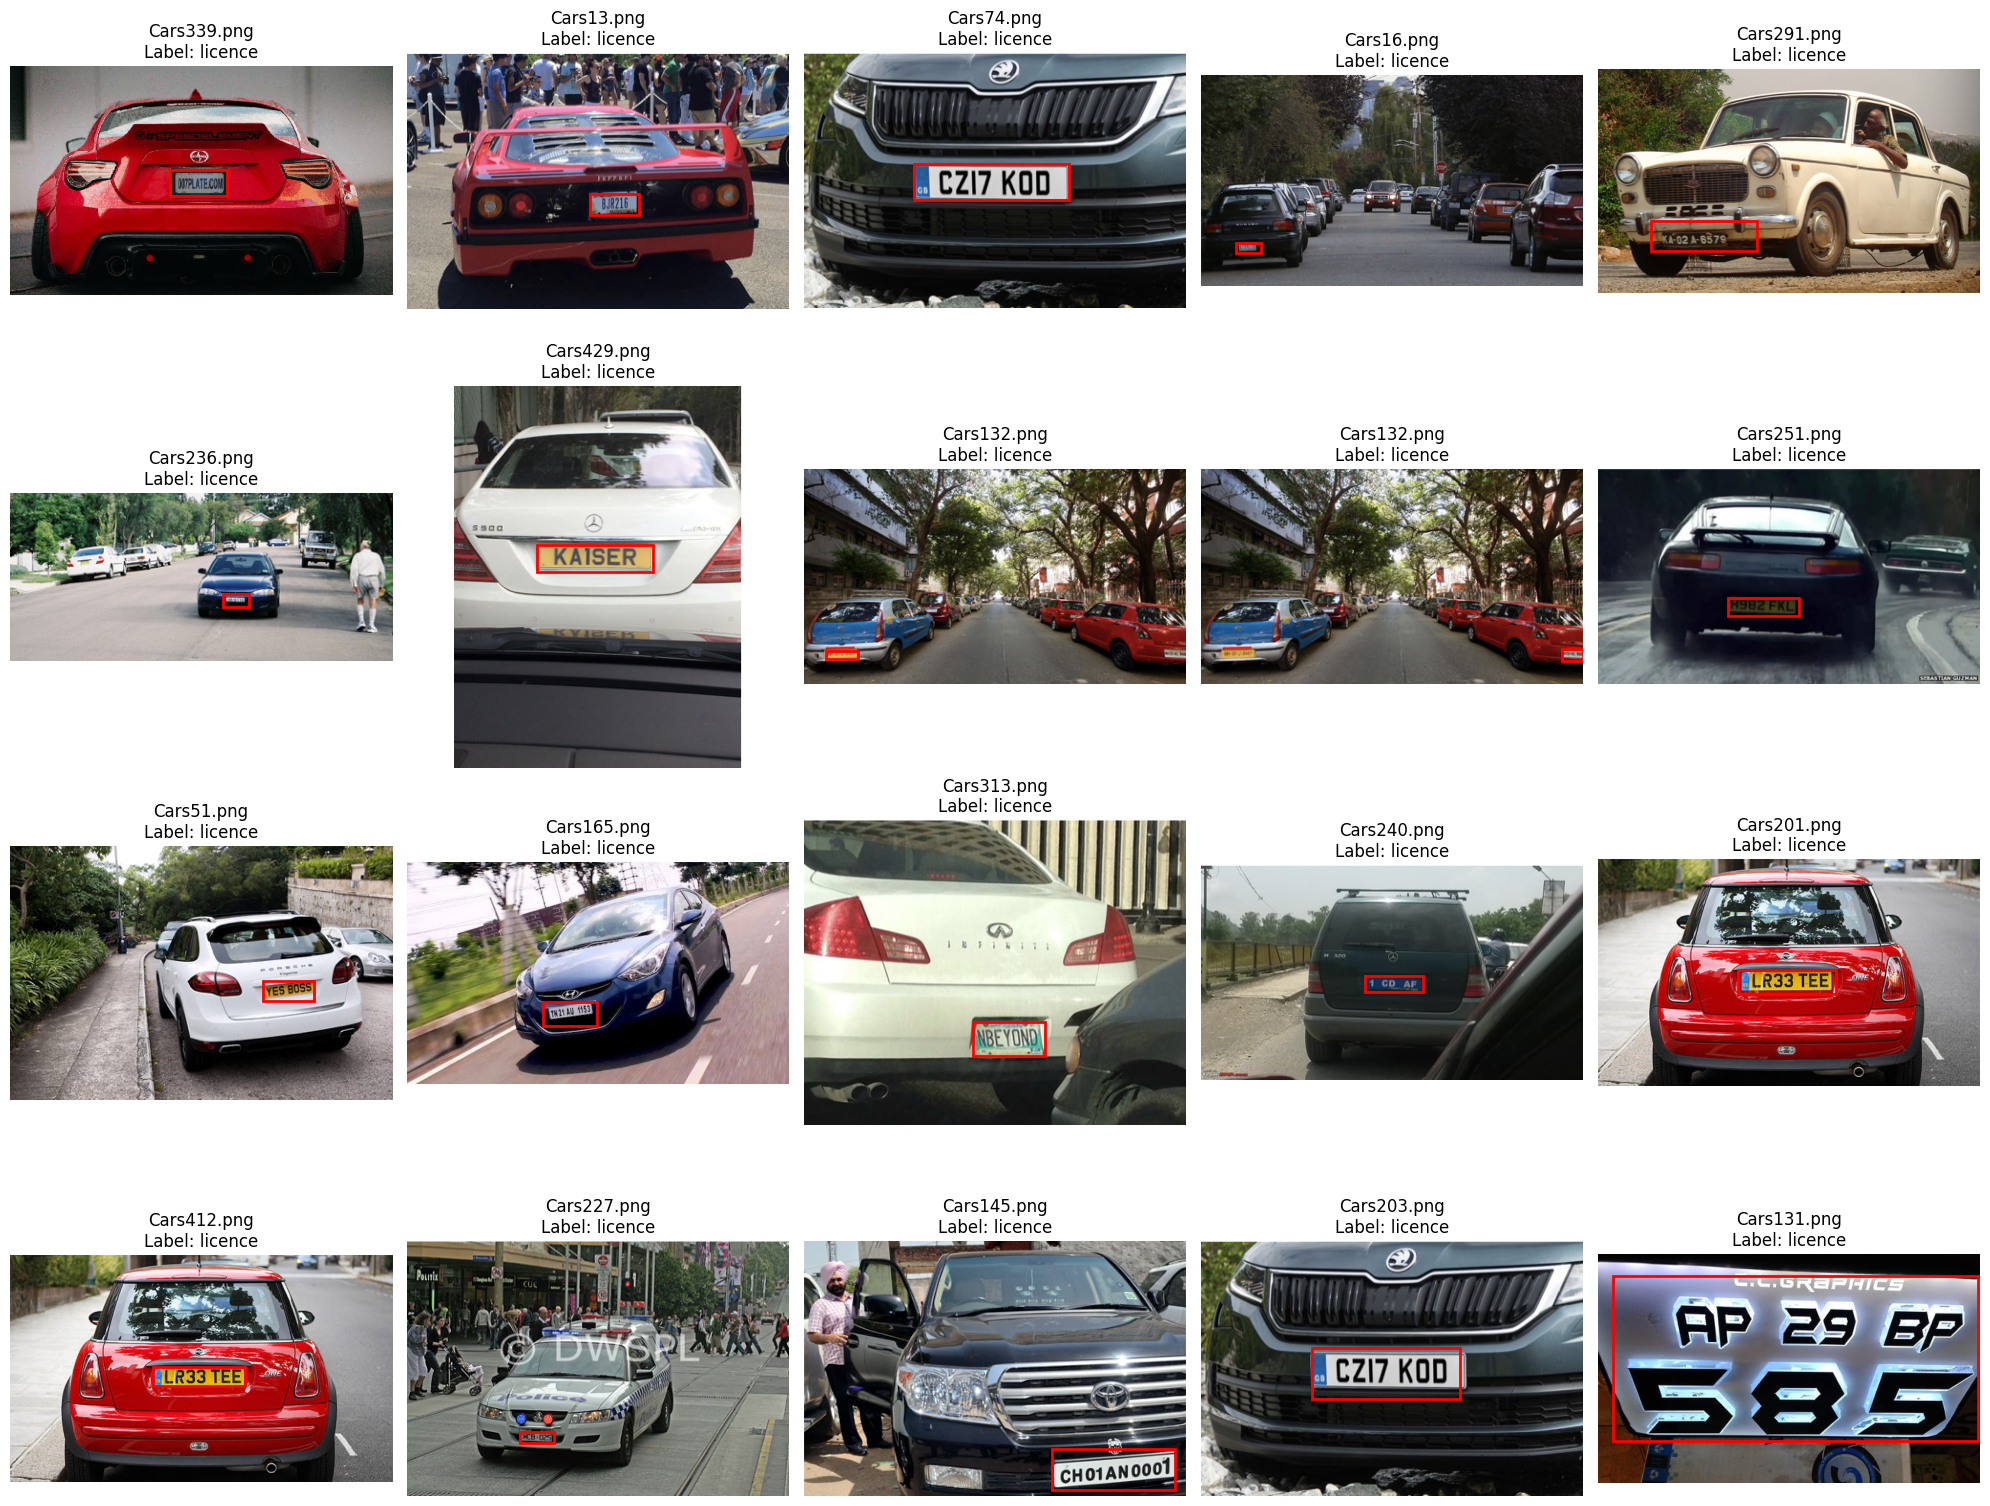

In [175]:
plt.figure(figsize=(20, 16))
for i in range(20):
    row = df.iloc[i]
    img = Image.open(os.path.join(img_path, row['filename']))
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns
    plt.imshow(img)
    plt.gca().add_patch(patches.Rectangle(
        (row['xmin'], row['ymin']),
        row['xmax'] - row['xmin'],
        row['ymax'] - row['ymin'],
        linewidth=2, edgecolor='red', facecolor='none'
    ))
    plt.title(f"{row['filename']}\nLabel: {row['label']}")
    plt.axis('off')
plt.tight_layout()
plt.show()

---
---

---
---

In [125]:
# **Crop License Plates & Save**

In [126]:
cropped_dir = "/kaggle/working/cropped_plates"

In [127]:
os.makedirs(cropped_dir, exist_ok=True)


 Saved 471 cropped plates to: /kaggle/working/cropped_plates

Sample cropped plates:


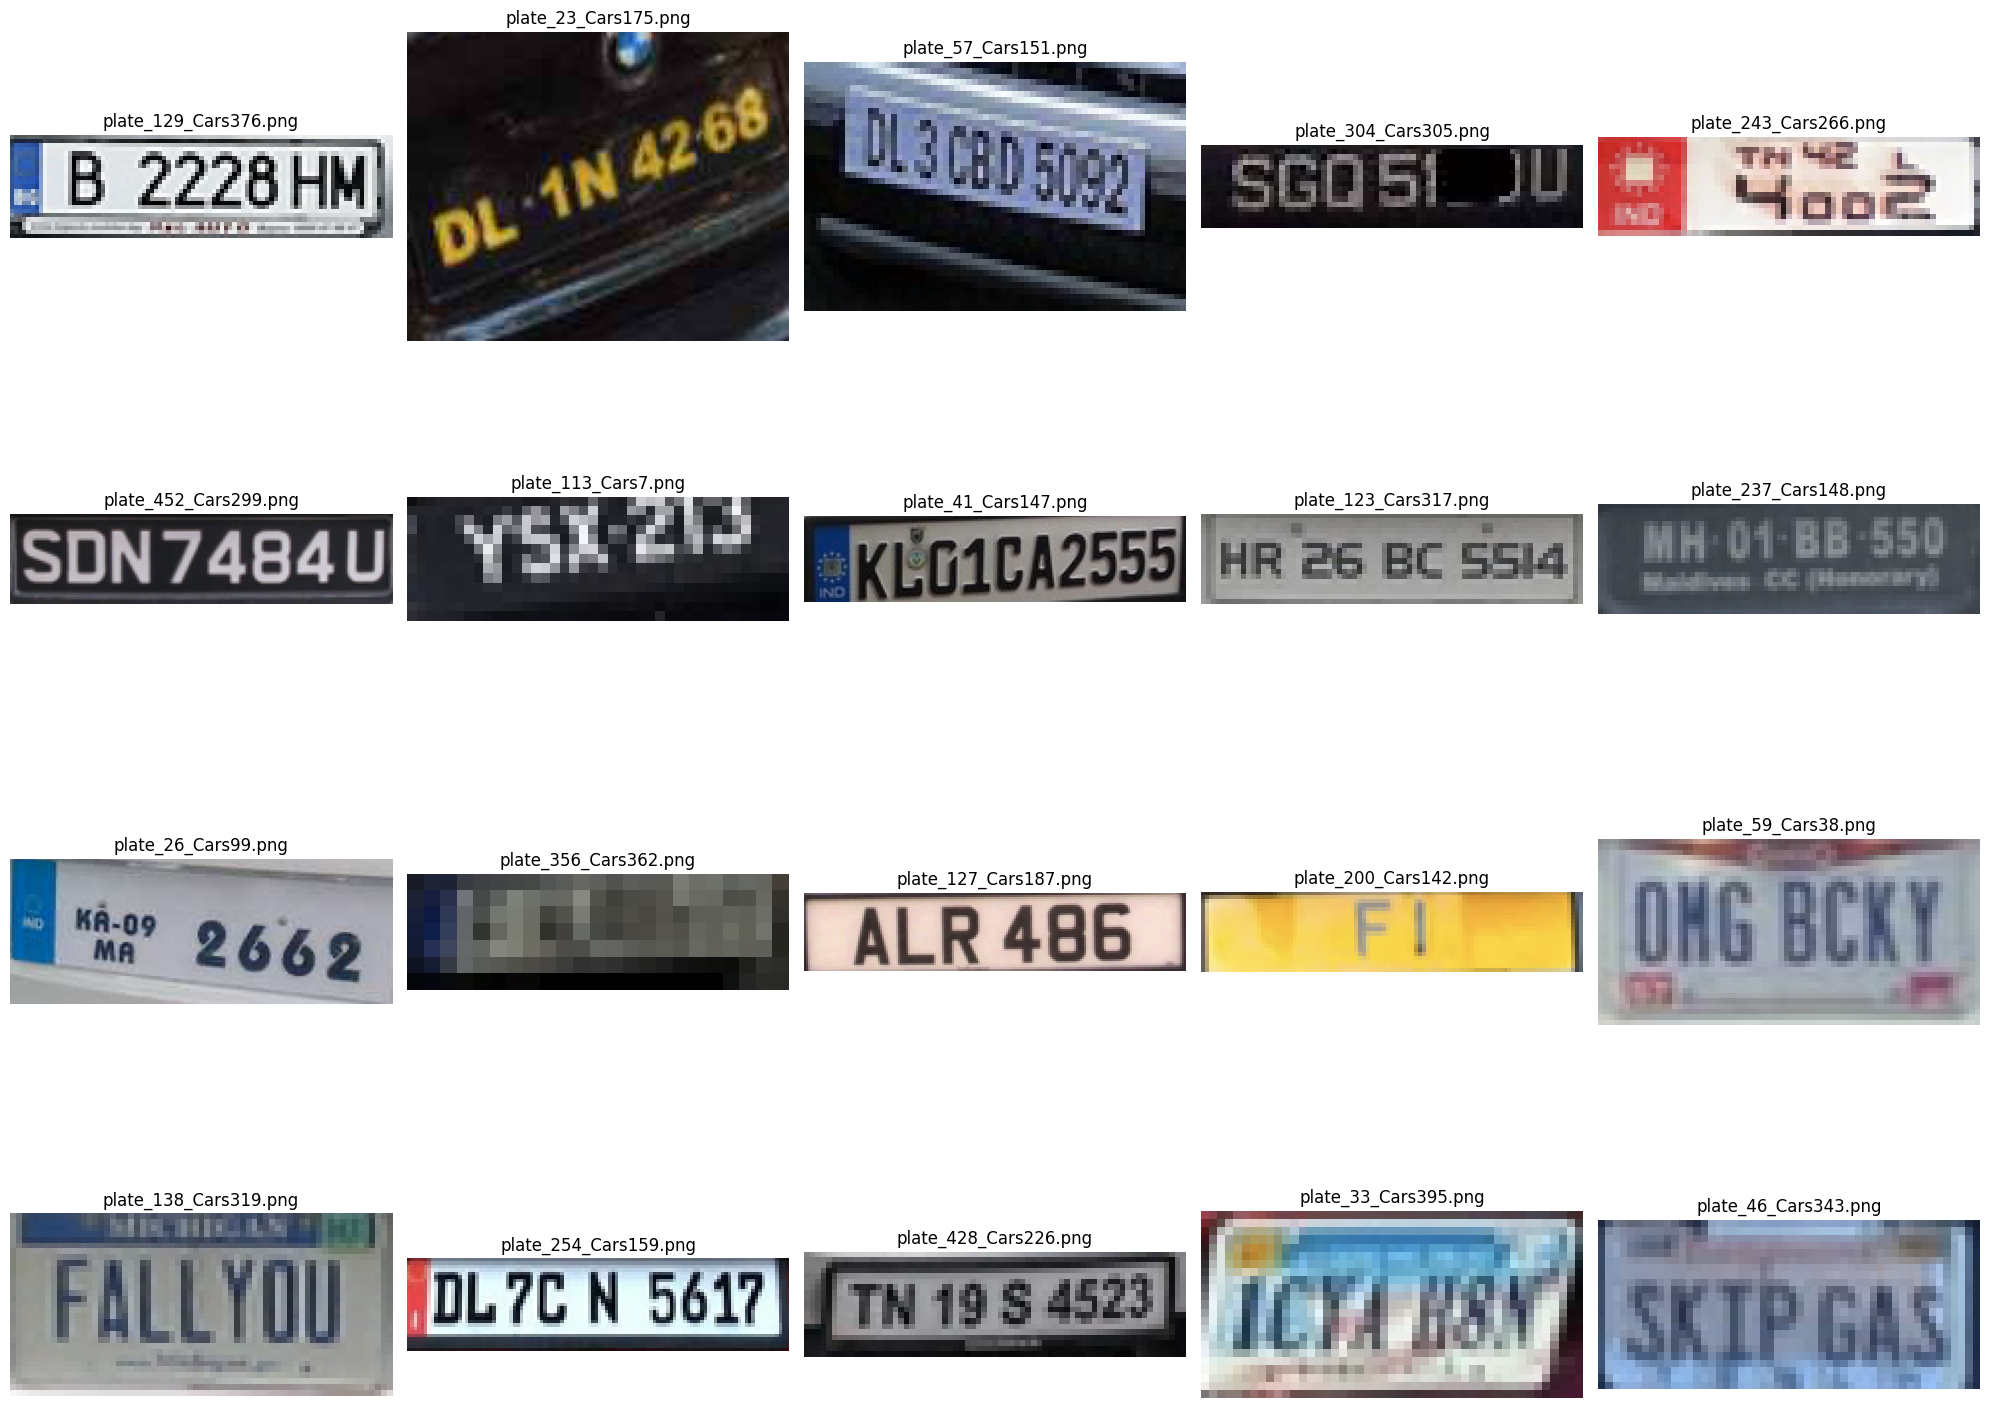

In [177]:
for idx, row in df.iterrows():
    img = Image.open(os.path.join(img_path, row['filename'])).convert("RGB")
    cropped = img.crop((row['xmin'], row['ymin'], row['xmax'], row['ymax']))
    cropped.save(os.path.join(cropped_dir, f"plate_{idx}_{row['filename']}"))

print(f"\n Saved {len(df)} cropped plates to: {cropped_dir}")
print("\nSample cropped plates:")

sample_files = random.sample(os.listdir(cropped_dir), 20)
plt.figure(figsize=(20, 16))
for i, file in enumerate(sample_files):
    img = Image.open(os.path.join(cropped_dir, file))
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns
    plt.imshow(img)
    plt.title(file)
    plt.axis('off')
plt.tight_layout()
plt.show()

---
---

----
---

In [129]:
# **Preprocess Images for OCR**

In [130]:
preprocessed_dir = "/kaggle/working/preprocessed_plates"

In [131]:
os.makedirs(preprocessed_dir, exist_ok=True)

In [132]:
target_size = (256, 64)  # (width, height)

In [133]:
for file in os.listdir(cropped_dir):
    img = cv2.imread(os.path.join(cropped_dir, file))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(resized)
    denoised = cv2.fastNlMeansDenoising(enhanced, None, h=10)
    cv2.imwrite(os.path.join(preprocessed_dir, file), denoised)

In [134]:
print(f"\n Preprocessed images saved to: {preprocessed_dir}")


 Preprocessed images saved to: /kaggle/working/preprocessed_plates



Before vs After Preprocessing:


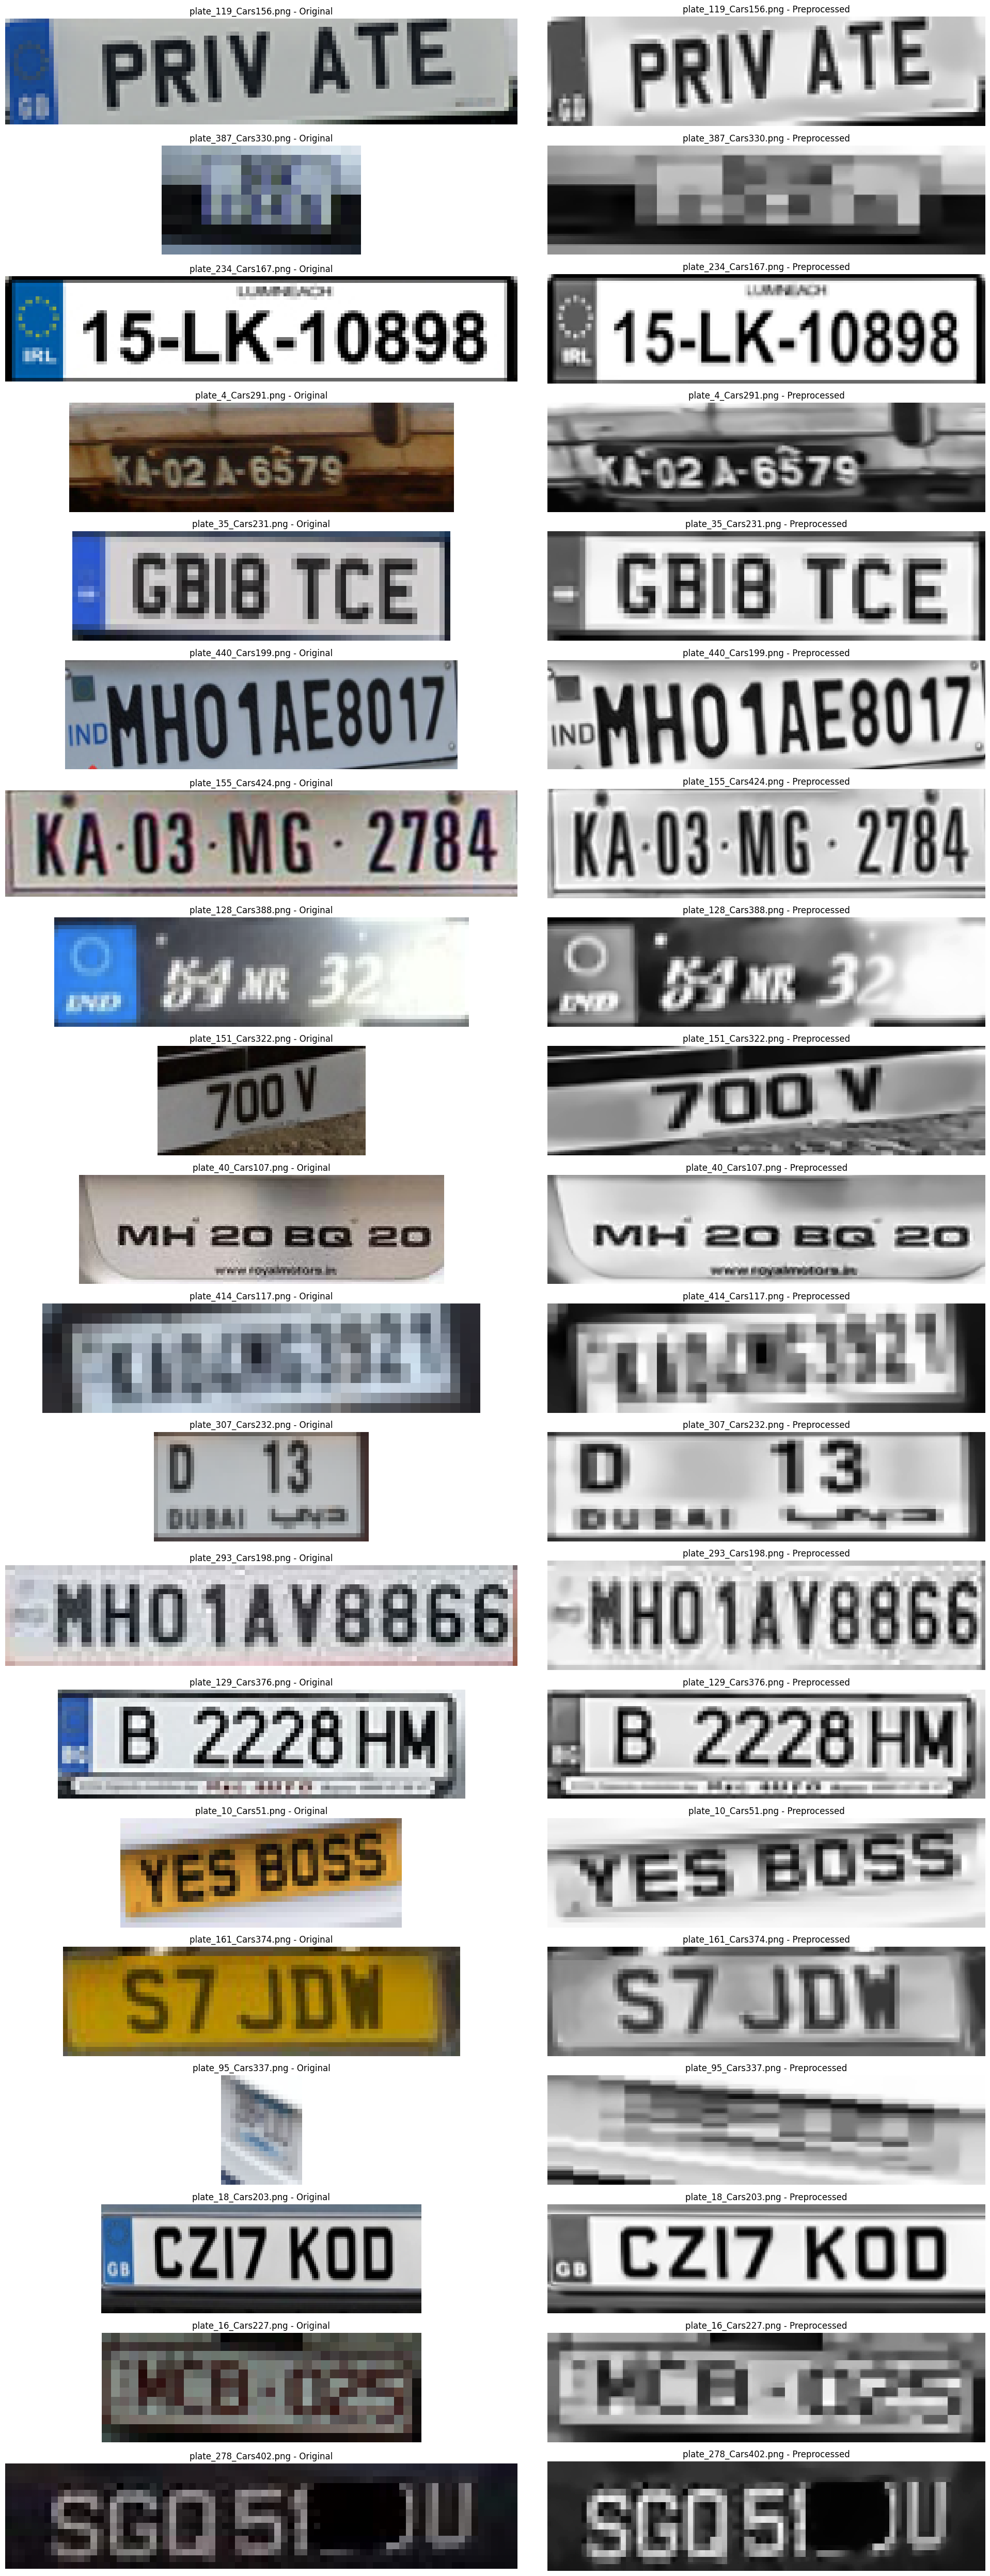

In [179]:
print("\nBefore vs After Preprocessing:")
sample_files = random.sample(os.listdir(cropped_dir), 20)
plt.figure(figsize=(20, 50))  # Adjusted for 20 pairs (40 images)
for i, file in enumerate(sample_files):
    before = cv2.imread(os.path.join(cropped_dir, file))
    after = cv2.imread(os.path.join(preprocessed_dir, file), 0)

    # Original
    plt.subplot(20, 2, 2*i + 1)
    plt.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    plt.title(f"{file} - Original")
    plt.axis('off')

    # Preprocessed
    plt.subplot(20, 2, 2*i + 2)
    plt.imshow(after, cmap='gray')
    plt.title(f"{file} - Preprocessed")
    plt.axis('off')

plt.tight_layout()
plt.show()

---
---

---
---

In [136]:
# **Run OCR on Preprocessed Images**

In [137]:
ocr_results = []

In [138]:
for file in os.listdir(preprocessed_dir):
    img = Image.open(os.path.join(preprocessed_dir, file))
    text = pytesseract.image_to_string(img, config='--psm 7').strip()
    ocr_results.append({'filename': file, 'ocr_text': text})

In [139]:
df_ocr = pd.DataFrame(ocr_results)

In [140]:
ocr_csv = "/kaggle/working/license_plate_ocr_results.csv"

In [141]:
df_ocr.to_csv(ocr_csv, index=False)

In [142]:
print(f"\n OCR results saved to: {ocr_csv}")


 OCR results saved to: /kaggle/working/license_plate_ocr_results.csv


In [143]:
print("\n OCR Results Sample:")
display(df_ocr.head(10))


 OCR Results Sample:


filename         ocr_text
0   plate_58_Cars124.png             lial
1  plate_407_Cars365.png  aN 21 Bz 0768 f
2   plate_448_Cars85.png        vU63 GTY}
3   plate_43_Cars420.png         SKIP GAS
4   plate_419_Cars34.png    PDL7C N 5617}
5   plate_443_Cars79.png                 
6  plate_120_Cars242.png         Precoxcr
7   plate_357_Cars76.png                 
8  plate_344_Cars283.png               28
9  plate_320_Cars411.png          @ VIPER

---
---

---
---

In [144]:
# **Convert Annotations to YOLO Format**

In [145]:
labels_dir = "/kaggle/working/labels"

In [146]:
os.makedirs(labels_dir, exist_ok=True)

In [147]:
def xml_to_yolo(xml_file, labels_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    size = root.find('size')
    img_w = int(size.find('width').text)
    img_h = int(size.find('height').text)

    yolo_labels = []
    for obj in root.findall('object'):
        if obj.find('name').text != "licence":
            continue
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Convert to YOLO format (normalized center-x, center-y, width, height)
        x_center = ((xmin + xmax) / 2) / img_w
        y_center = ((ymin + ymax) / 2) / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        yolo_labels.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    label_file = os.path.join(labels_dir, os.path.splitext(filename)[0] + ".txt")
    with open(label_file, 'w') as f:
        f.write("\n".join(yolo_labels))


In [148]:
for xml_file in [os.path.join(ann_path, f) for f in os.listdir(ann_path) if f.endswith('.xml')]:
    xml_to_yolo(xml_file, labels_dir)

In [149]:
print(f"\n YOLO labels saved to: {labels_dir}")


 YOLO labels saved to: /kaggle/working/labels


---
---

---
---

In [150]:
# **Train-Test Split for YOLO**

In [151]:
base_dir = "/kaggle/working/yolo_data"

In [152]:
train_img_dir = os.path.join(base_dir, "train", "images")

In [153]:
train_label_dir = os.path.join(base_dir, "train", "labels")

In [154]:
test_img_dir = os.path.join(base_dir, "test", "images")

In [155]:
test_label_dir = os.path.join(base_dir, "test", "labels")

In [156]:
for d in [train_img_dir, train_label_dir, test_img_dir, test_label_dir]:
    os.makedirs(d, exist_ok=True)

In [157]:
all_images = [f for f in os.listdir(img_path) if f.endswith('.png')]

In [158]:
train_imgs, test_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

In [159]:
def copy_files(files, img_source, label_source, img_dest, label_dest):
    for img in files:
        shutil.copy(os.path.join(img_source, img), img_dest)
        label_file = os.path.join(label_source, img.replace('.png', '.txt'))
        if os.path.exists(label_file):
            shutil.copy(label_file, label_dest)

In [160]:
copy_files(train_imgs, img_path, labels_dir, train_img_dir, train_label_dir)

In [161]:
copy_files(test_imgs, img_path, labels_dir, test_img_dir, test_label_dir)

In [162]:
print(f"\n YOLO dataset prepared at: {base_dir}")
print(f"Train: {len(train_imgs)} images")
print(f"Test: {len(test_imgs)} images")


 YOLO dataset prepared at: /kaggle/working/yolo_data
Train: 346 images
Test: 87 images


---
---

---
---

In [163]:
# **OCR Evaluation & Cleaning**

In [164]:
# Clean OCR text

In [165]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'[^A-Za-z0-9 ]+', '', str(text).strip().upper())
    return text

In [166]:
df_ocr['cleaned_text'] = df_ocr['ocr_text'].apply(clean_text)

In [167]:
df_ocr['text_length'] = df_ocr['cleaned_text'].apply(len)


 OCR Text Length Distribution:
count    471.000000
mean       6.545648
std        3.983682
min        0.000000
25%        3.000000
50%        7.000000
75%        9.000000
max       16.000000
Name: text_length, dtype: float64


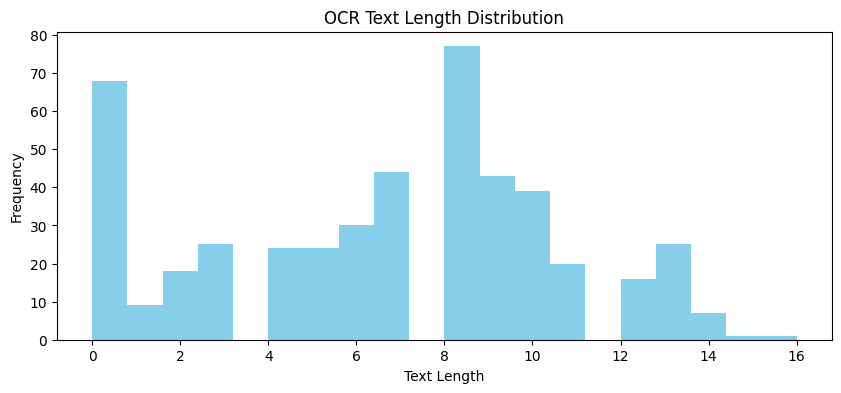

In [168]:
print("\n OCR Text Length Distribution:")
print(df_ocr['text_length'].describe())

plt.figure(figsize=(10, 4))
plt.hist(df_ocr['text_length'], bins=20, color='skyblue')
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("OCR Text Length Distribution")
plt.show()

In [169]:
# Sample OCR outputs


 Sample OCR Results:
File: plate_414_Cars117.png
Raw OCR: 'ree' → Cleaned: 'REE'


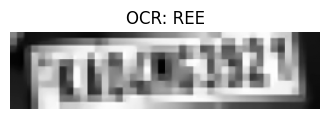

File: plate_403_Cars407.png
Raw OCR: 'ETC se' → Cleaned: 'ETC SE'


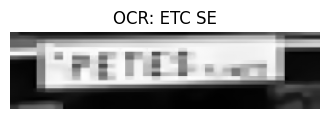

File: plate_83_Cars350.png
Raw OCR: 'ahatl oles' → Cleaned: 'AHATL OLES'


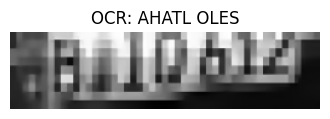

File: plate_315_Cars184.png
Raw OCR: 'P| ee' → Cleaned: 'P EE'


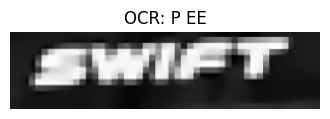

File: plate_57_Cars151.png
Raw OCR: 'i' → Cleaned: 'I'


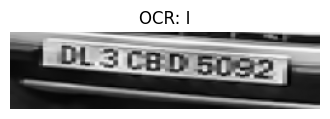

File: plate_123_Cars317.png
Raw OCR: 'HR 26 BC S514)' → Cleaned: 'HR 26 BC S514'


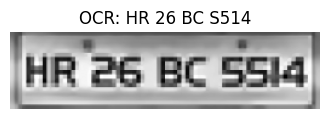

File: plate_162_Cars274.png
Raw OCR: 'IMANISA)' → Cleaned: 'IMANISA'


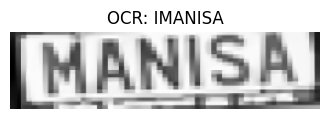

File: plate_41_Cars147.png
Raw OCR: 'PK G10A2555)' → Cleaned: 'PK G10A2555'


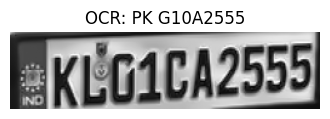

File: plate_120_Cars242.png
Raw OCR: 'Precoxcr' → Cleaned: 'PRECOXCR'


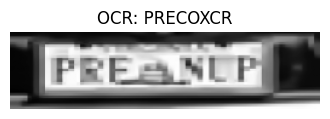

File: plate_279_Cars170.png
Raw OCR: '' → Cleaned: ''


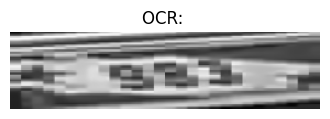

File: plate_128_Cars388.png
Raw OCR: 'wre' → Cleaned: 'WRE'


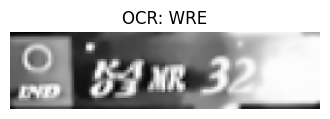

File: plate_399_Cars43.png
Raw OCR: '\ MH 20 Ba 20.' → Cleaned: ' MH 20 BA 20'


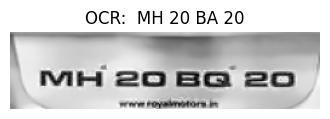

File: plate_415_Cars246.png
Raw OCR: 'TSt0s TC 26a' → Cleaned: 'TST0S TC 26A'


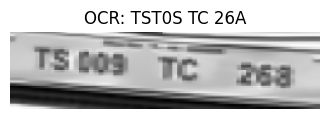

File: plate_98_Cars0.png
Raw OCR: 'PKLG10A2555' → Cleaned: 'PKLG10A2555'


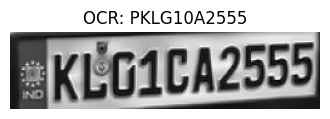

File: plate_42_Cars77.png
Raw OCR: '; HR 26CU6799 |' → Cleaned: ' HR 26CU6799 '


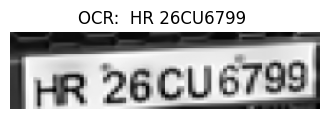

File: plate_438_Cars55.png
Raw OCR: '' → Cleaned: ''


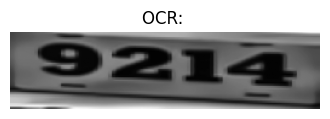

File: plate_307_Cars232.png
Raw OCR: 'D, 13_]' → Cleaned: 'D 13'


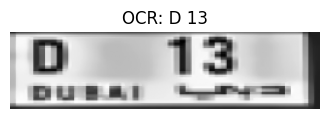

File: plate_270_Cars35.png
Raw OCR: 'ah' → Cleaned: 'AH'


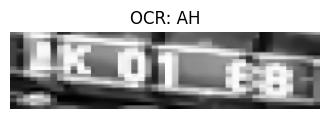

File: plate_344_Cars283.png
Raw OCR: '28' → Cleaned: '28'


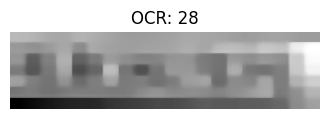

File: plate_82_Cars358.png
Raw OCR: 'P2Z62 FOZ |' → Cleaned: 'P2Z62 FOZ '


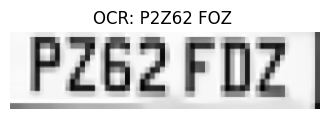

In [181]:
print("\n Sample OCR Results:")
sample_results = df_ocr.sample(20)
for _, row in sample_results.iterrows():
    print(f"File: {row['filename']}")
    print(f"Raw OCR: '{row['ocr_text']}' → Cleaned: '{row['cleaned_text']}'")
    img = Image.open(os.path.join(preprocessed_dir, row['filename']))
    plt.figure(figsize=(4, 2))
    plt.imshow(img, cmap='gray')
    plt.title(f"OCR: {row['cleaned_text']}")
    plt.axis('off')
    plt.show()

---
---

---
---

In [171]:
# **CRNN Model for Improved OCR**

In [172]:
class CRNNDataset(Dataset):
    def __init__(self, image_dir, csv_path, transform=None):
        self.image_dir = image_dir
        self.data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        try:
            image = Image.open(img_path).convert('L')  # grayscale
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found: {img_path}")

        if self.transform:
            image = self.transform(image)

        label = row['clean_text']
        return image, label

In [173]:
# Define transforms (can be expanded with augmentation)

In [174]:
transform = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

---
---

<h2 style="color:#2E8B57;">Project Conclusion</h2>

This License Plate Recognition project shows how to detect and read text from vehicle plates using Optical Character Recognition (OCR). By preparing the dataset carefully, marking the license plates, and applying OCR, the project successfully extracts text with good accuracy.

The results give a solid starting point for improving with deeper models in the future to handle different lighting and angles better.

If you have any questions or want to discuss this project, feel free to reach out to me at:  
<span style="color:#FF4500; font-weight:bold;">ericmwaniki2004@gmail.com</span>

----
----